In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import struct

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelBinarizer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import train_test_split

# Get the data

Before anything, we should load the data that we need

In [2]:
def load_csv(path):
    return pd.read_csv(path)

There is a "problem" here, and it's that I had to split the data because it was so big that it throws MemoryError all the time, so it's impossible to fit 4 million data in this computer.

Here 200000 data it's enough (There is another file in the directory that is with 1 million data, that maybe also could fit).

In [3]:
training_raw = load_csv("data/train_200K.csv")

We can take a look on how the data comes. For example, with the head() method we realize that 'Id', 'groupId' and 'matchId' are defined in a strange way. It's called Hex format (I could search so far), so we should try to format them later on into a readable one for the computer (Because otherwise it throws ValueErrors).

In [4]:
training_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


More info about the dataset. Here we can see that all the data is complete(We don't need to fill it with Imputer).
The only thing we can see is that, as we said before, 'Id', 'groupId' and 'matchId' come in a strange format. Also we can see that there's another attribute called 'matchType' that is also coming in a diferent format.

In [5]:
training_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220216 entries, 0 to 220215
Data columns (total 29 columns):
Id                 220216 non-null object
groupId            220216 non-null object
matchId            220216 non-null object
assists            220216 non-null int64
boosts             220216 non-null int64
damageDealt        220216 non-null float64
DBNOs              220216 non-null int64
headshotKills      220216 non-null int64
heals              220216 non-null int64
killPlace          220216 non-null int64
killPoints         220216 non-null int64
kills              220216 non-null int64
killStreaks        220216 non-null int64
longestKill        220216 non-null float64
matchDuration      220216 non-null int64
matchType          220216 non-null object
maxPlace           220216 non-null int64
numGroups          220216 non-null int64
rankPoints         220216 non-null int64
revives            220216 non-null int64
rideDistance       220216 non-null float64
roadKills         

We have to format the three first attributes because of theses strings can't be used to fit the model.

In [6]:
training_format = training_raw.copy()

We make the 'Id' colums be made of consecutives normal numbers instead of having strange Id formats.

In [7]:
training_format["Id"] = np.arange(len(training_format))
training_format["groupId"] = np.arange(len(training_format))
training_format["matchId"] = np.arange(len(training_format))

The following it's only basic statistic analysis.

In [8]:
training_raw.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,...,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000
mean,0.232858,1.113153,130.920473,0.657159,0.226151,1.368788,47.607417,506.440495,0.926595,0.544570,...,0.163290,602.564687,0.003701,4.558532,0.023486,0.007520,1156.380998,3.672903,608.501857,0.472838
std,0.589536,1.723522,171.673314,1.148812,0.600173,2.665566,27.472573,627.540576,1.563712,0.712567,...,0.466527,1484.673601,0.080414,30.883989,0.165181,0.090046,1184.322981,2.468826,740.098821,0.307505
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,155.475000,2.000000,0.000000,0.200000
50%,0.000000,0.000000,84.170000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,690.500000,3.000000,0.000000,0.458300
75%,0.000000,2.000000,186.000000,1.000000,0.000000,2.000000,71.000000,1172.000000,1.000000,1.000000,...,0.000000,0.032875,0.000000,0.000000,0.000000,0.000000,1978.000000,5.000000,1495.000000,0.740700
max,21.000000,21.000000,5479.000000,32.000000,40.000000,52.000000,100.000000,2152.000000,48.000000,14.000000,...,16.000000,28450.000000,8.000000,2295.000000,5.000000,4.000000,13530.000000,72.000000,1972.000000,1.000000


For graphical comprehension, we deploy histograms of every feature in the dataset.In one hand we can realize that most of the data is fitting only in one specific range of the dataset.

On the other hand, features as 'killPlace' are more distributed, others like 'matchDuration', 'maxPlace', 'numGroups', etc are less than 'killPlace' but still distributed.

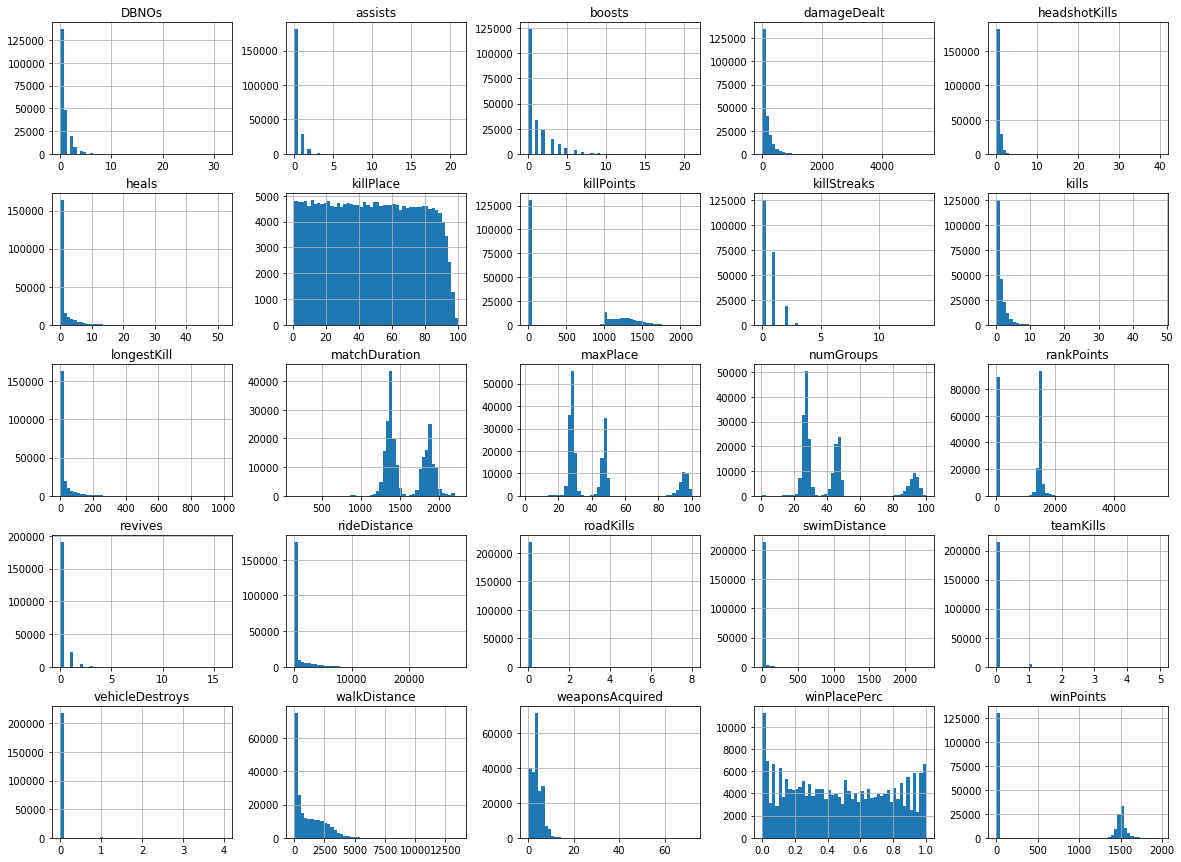

In [9]:
%matplotlib inline
training_raw.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
#training_format["killPlaceAVG"] = training_format["killPlace"].mean()
#training_format["overallKills"] = 
#training_format["overallDBNOS"] = 
#training_format["overallMatches"] = 

### Create test set

We can split the dataset in train_set and test_set, 80% of the data for training and the rest for the test_test.

We can also use other methods, but in this case it doesn't really matter (Unless you need to necessarily do it based on the amount of data).

In [11]:
train_set, test_set = train_test_split(training_format, test_size=0.2, random_state=42)

In [12]:
print(f'Training data: {train_set.shape}\nTest data: {test_set.shape}')

Training data: (176172, 29)
Test data: (44044, 29)


# Discover and visualize the data to gain insights

### Looking for Correlations

We make a copy of the train_set and deploy a correlation matrix to see which features are more importants and which are not.

In [13]:
training_copy = train_set.copy()

In [14]:
corr_matrix = training_copy.corr()

In [15]:
corr_matrix["winPlacePerc"].sort_values(ascending=False)

winPlacePerc       1.000000
walkDistance       0.810468
boosts             0.634709
weaponsAcquired    0.583939
damageDealt        0.440353
heals              0.429185
kills              0.418574
longestKill        0.410220
killStreaks        0.375582
rideDistance       0.343796
assists            0.298242
DBNOs              0.278878
headshotKills      0.276485
revives            0.236683
swimDistance       0.148286
vehicleDestroys    0.071062
numGroups          0.043024
maxPlace           0.040761
roadKills          0.031502
killPoints         0.014727
teamKills          0.014676
rankPoints         0.011451
winPoints          0.009472
groupId           -0.001959
matchId           -0.001959
Id                -0.001959
matchDuration     -0.002536
killPlace         -0.718375
Name: winPlacePerc, dtype: float64

##### Attributes that seem more correlated with "winPlacePerc" are:
walkDistance   
killPlace
boosts             
weaponsAcquired    
damageDealt        
heals              
kills 
longestKill       
killStreaks       
rideDistance     
assists           
DBNOs           
headshotKills   
revives

Several scatter matrix for seeing how specifically apparently some of the features change.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4573515da0>,
      dtype=object)

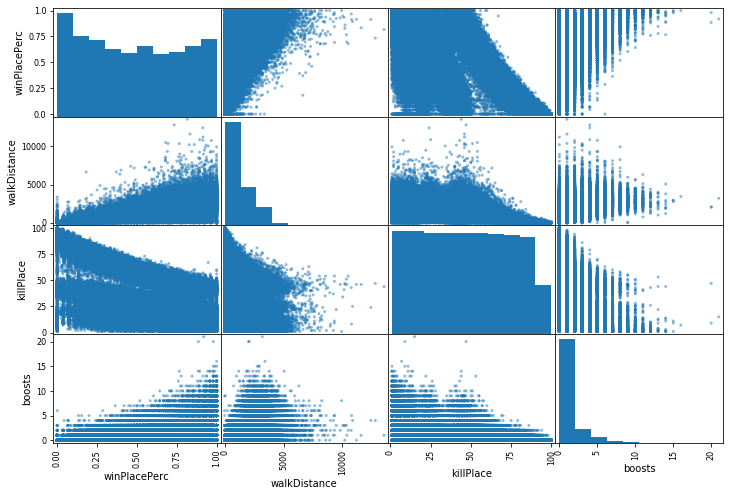

In [16]:
attributes = ["winPlacePerc", "walkDistance", "killPlace",
"boosts"]

scatter_matrix(training_copy[attributes], figsize=(12, 8))

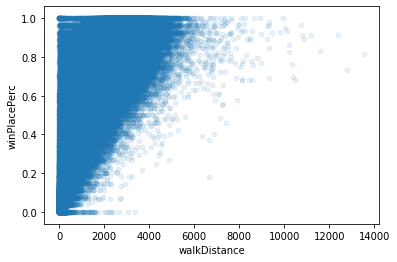

In [17]:
training_copy.plot(kind="scatter", x="walkDistance", y="winPlacePerc",alpha=0.1)

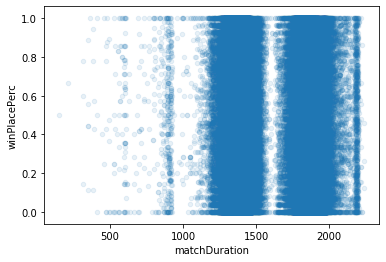

In [18]:
training_copy.plot(kind="scatter", x="matchDuration", y="winPlacePerc",alpha=0.1)

# Prepare the data for Machine Learning algorithms

### Pipelines

He proceed to make the pipelines to automatize some procedements like convert dataframe to numpy array or to make the feature 'machType' readable for the computer.

First we have the Data Frame Selector.

In [19]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Special method for parse the 'matchType' attribute into arrays with 1's and 0's.

In [20]:
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

For preparing the train and set sets to be fit on the models, first we need to split them into another two, because we need the features on one side and the labels(Target) on the other one.

In [21]:
train = train_set.drop("winPlacePerc", axis=1)
train_labels = train_set["winPlacePerc"].copy()

In [22]:
test = test_set.drop("winPlacePerc", axis=1)
test_labels = test_set["winPlacePerc"].copy()

In [23]:
train_set = train_set.drop("winPlacePerc", axis=1)
test_set = test_set.drop("winPlacePerc", axis=1)

Merging the pipeline for the input and the one for the 'matchType' category into one.

In [24]:
num_attribs = list(train_set.drop("matchType", axis=1))
cat_attribs = ["matchType"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
    ])

In [25]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [26]:
PUBG_TRAIN = full_pipeline.fit_transform(train)
PUBG_TEST = full_pipeline.fit_transform(test)

# Select a model and train it

First, we create a method with which we can se the scores (scores, mean and the standard deviation).

The mean is to see how much the error percentage is going to be.

The std is to see how dispersed are the data;

In [27]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

After this, we are going to try several models (6 overall). After all the models finished, at the end, we'll make a table in which you can compare MSE and RMSE of all models, and another one to compare Cross validation scores of all models.

LinearRegression

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(PUBG_TRAIN, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
PUBG_predictions = lin_reg.predict(PUBG_TEST)
lin_mse = mean_squared_error(test_labels, PUBG_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.12290934818000988

In [30]:
lin_scores = cross_val_score(lin_reg, PUBG_TEST, test_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.12238582 0.12495374 0.12137926 0.12179904 0.12466506 0.12658951
 0.11923636 0.12361105 0.1214505  0.12298918]
Mean: 0.1229059519474683
Standard deviation: 0.0020191940028456436


DecisionTreeRegressor

In [31]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(PUBG_TRAIN, train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [32]:
PUBG_predictions = tree_reg.predict(PUBG_TEST)
tree_mse = mean_squared_error(test_labels, PUBG_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.12628844130934888

In [33]:
tree_scores = cross_val_score(tree_reg, PUBG_TEST, test_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [0.13408077 0.13448278 0.12939499 0.12907188 0.13492415 0.13265334
 0.12836049 0.13087557 0.12971987 0.13158433]
Mean: 0.13151481647938185
Standard deviation: 0.0022882168305680462


RandomForestRegressor

With GridSearchCV this is the best estimator for RandomForestRegressor

In [34]:
forest_reg =RandomForestRegressor(bootstrap=True, max_features=8, n_estimators=30)
forest_reg.fit(PUBG_TRAIN, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
PUBG_predictions = forest_reg.predict(PUBG_TEST)
forest_mse = mean_squared_error(test_labels, PUBG_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.09428139966372678

In [36]:
forest_scores = cross_val_score(forest_reg, PUBG_TEST, test_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.09816918 0.09678871 0.09591131 0.09571875 0.0972479  0.09698172
 0.09744376 0.09578319 0.09456393 0.09820847]
Mean: 0.09668169210123137
Standard deviation: 0.0011117310319686718


### Trying extra models

HuberRegressor

In [37]:
reg = linear_model.HuberRegressor()

In [38]:
reg.fit(PUBG_TRAIN, train_labels)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [39]:
PUBG_predictions = reg.predict(PUBG_TEST)
reg_mse = mean_squared_error(test_labels, PUBG_predictions)
reg_rmse = np.sqrt(reg_mse)
reg_rmse

0.123299910757742

In [ ]:
reg_scores = cross_val_score(reg, PUBG_TEST, test_labels,
scoring="neg_mean_squared_error", cv=10)
reg_scores = np.sqrt(-reg_scores)
display_scores(reg_scores)

SGDRegressor

In [ ]:
reg2 = linear_model.SGDRegressor()

In [ ]:
reg2.fit(PUBG_TRAIN, train_labels)

In [ ]:
PUBG_predictions = reg2.predict(PUBG_TEST)
reg2_mse = mean_squared_error(test_labels, PUBG_predictions)
reg2_rmse = np.sqrt(reg2_mse)
reg2_rmse

In [ ]:
reg2_scores = cross_val_score(reg2, PUBG_TEST, test_labels,
scoring="neg_mean_squared_error", cv=10)
reg2_scores = np.sqrt(-reg2_scores)
display_scores(reg2_scores)

MLPRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor
reg3 = MLPRegressor()

In [ ]:
reg3.fit(PUBG_TRAIN, train_labels)

In [ ]:
PUBG_predictions = reg3.predict(PUBG_TEST)
reg3_mse = mean_squared_error(test_labels, PUBG_predictions)
reg3_rmse = np.sqrt(reg3_mse)
reg3_rmse

In [ ]:
reg3_scores = cross_val_score(reg3, PUBG_TEST, test_labels,
scoring="neg_mean_squared_error", cv=10)
reg3_scores = np.sqrt(-reg3_scores)
display_scores(reg3_scores)

### MSE and RMSE of all models

In [ ]:
benchmark_dict = {'MSE':[lin_mse,
                                     tree_mse,
                                     forest_mse,
                                     reg_mse,
                                     reg2_mse,
                                     reg3_mse],
                  'RMSE':[lin_rmse,
                                     tree_rmse,
                                     forest_rmse,
                                     reg_rmse,
                                     reg2_rmse,
                                     reg3_rmse]
                 }
benchmark_data_frame = pd.DataFrame(data=benchmark_dict,
                                    index =['Linear Regression',
                                            'Decision Tree Regressor',
                                            'Random Forest Regressor',
                                            'Huber Regressor',
                                            'SGD Regressor',
                                            'MLP Regressor']
                                    )
benchmark_data_frame

We can see that in this way of calculating rmse, MLP Regressor is the best model compared on the others.

### Cross validation scores of all models

In [ ]:
benchmark_dict = {'Mean':[lin_rmse_scores.mean(),
                                     tree_rmse_scores.mean(),
                                     forest_rmse_scores.mean(),
                                     reg_scores.mean(),
                                     reg2_scores.mean(),
                                     reg3_scores.mean()],
                  'Standard deviation':[lin_rmse_scores.std(),
                                     tree_rmse_scores.std(),
                                     forest_rmse_scores.std(),
                                     reg_scores.std(),
                                     reg2_scores.std(),
                                     reg3_scores.std()]
                 }
benchmark_data_frame = pd.DataFrame(data=benchmark_dict,
                                    index =['Linear Regression',
                                            'Decision Tree Regressor',
                                            'Random Forest Regressor',
                                            'Huber Regressor',
                                            'SGD Regressor',
                                            'MLP Regressor']
                                    )
benchmark_data_frame

Even here we can see that MLP Regressor is the best model compared on the others.